This code reads in a multiple data file that contains a time series of the vertical profile of atmospheric variables and parameters associated with the Tracking Aerosol Convection Interactions Experiment (TRACER, https://armgov.svcs.arm.gov/research/campaigns/amf2021tracer). Some of these variables are one-dimensional, while others are two-dimensional. The code then ensures that the time component of each dataset matches, merges the data into one array, scales the data, and conducts k-means clustering. Finally, the code creates plots that shows the characteristics of the two clusters generated by the k-means clustering. 

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc4
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import metrics
from windrose import WindroseAxes
from scipy.stats import ttest_ind

In [2]:
# Set directories and files

DataDirectory = '/Local/Data/Directory/
PlotDirectory = '/Local/Plot/Directory/'

FieldProject = 'TRACER'

SetHour = 0.5


In [3]:
# Set up plotting

PlotLabels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']


In [4]:
# Load environmental data and convert times

Data = nc4.Dataset(DataDirectory + '/Environment/HoustonHalfHourlyInterpsonde_JJAS_2022.nc', 'r')

CAPE = np.array(Data.variables['cape'])[:]
ShallowShear = np.array(Data.variables['shallowshear'])[:]
DeepShear = np.array(Data.variables['deepshear'])[:]
Stability = np.array(Data.variables['lts'])[:]
SFCWindDirection = np.array(Data.variables['sfcWindDir'])[:]

WindSpeed = np.array(Data.variables['wspd'])[:, :]
qcWindSpeed  = np.array(Data.variables['qc_wspd'])[:, :]

RelativeHumidity = np.array(Data.variables['rh_scaled'])[:, :]
qcRelativeHumidity  = np.array(Data.variables['qc_rh_scaled'])[:, :]
qcRelativeHumidity2  = np.array(Data.variables['aqc_rh_scaled'])[:, :]

BaseTime_String = Data.variables['time'].units
DateTime_Minutes = np.array(Data.variables['time'])[:]

Data.close()

# Isolate surface wind speed
WindSpeed[qcWindSpeed != 0] = np.nan
SFCWindSpeed = WindSpeed[:, 0]

# Isolate surface relative humidity
RelativeHumidity[qcRelativeHumidity != 0] = np.nan
RelativeHumidity[qcRelativeHumidity2 != 0] = np.nan
SFCRelativeHumidity = RelativeHumidity[:, 0]

# Convert times
BaseTime = datetime.strptime(BaseTime_String[14::], '%Y-%m-%d %H:%M:%S')

EnvironmentDateTimes = []
for e in range(0, len(CAPE)):
    EnvironmentDateTimes = np.hstack((EnvironmentDateTimes, BaseTime + timedelta(minutes = int(DateTime_Minutes[e]))))

print(EnvironmentDateTimes)


[datetime.datetime(2022, 6, 1, 0, 0) datetime.datetime(2022, 6, 1, 0, 30)
 datetime.datetime(2022, 6, 1, 1, 0) ...
 datetime.datetime(2022, 9, 30, 22, 30)
 datetime.datetime(2022, 9, 30, 23, 0)
 datetime.datetime(2022, 9, 30, 23, 30)]


In [5]:
# Load precipitation data

Data = nc4.Dataset(DataDirectory + '/Precipitation/' + FieldProject + '_AOSMETprecip_' + str(SetHour) + 'hr.nc', 'r')

Precipitation = np.array(Data.variables['Precip_Accum'])[:]
BaseTime_String = Data.variables['Date_Time'].long_name
DateTime_Seconds = np.array(Data.variables['Date_Time'])[:]
Data.close()

# Convert times and round seconds
BaseTime = datetime.strptime(BaseTime_String[14::], '%Y-%m-%d %H:%M:%S')

PrecipitationDateTimes = []
for e in range(0, len(DateTime_Seconds)):
    dt = BaseTime + timedelta(seconds = int(DateTime_Seconds[e]))
    if dt.minute < 30 and dt.minute > 27:
        rounded_dt = dt.replace(minute=30, second=0, microsecond=0)
        PrecipitationDateTimes = np.hstack((PrecipitationDateTimes, rounded_dt))
    elif dt.minute > 57 and dt.minute <= 59:
        dt += timedelta(hours=1)
        rounded_dt = dt.replace(minute=0, second=0, microsecond=0)
        PrecipitationDateTimes = np.hstack((PrecipitationDateTimes, rounded_dt))   
    elif dt.minute > 0 and dt.minute < 2:
        rounded_dt = dt.replace(minute=0, second=0, microsecond=0)
        PrecipitationDateTimes = np.hstack((PrecipitationDateTimes, rounded_dt))
    else:
        PrecipitationDateTimes = np.hstack((PrecipitationDateTimes, dt))   
        
print(PrecipitationDateTimes)


[datetime.datetime(2022, 6, 1, 0, 0) datetime.datetime(2022, 6, 1, 0, 30)
 datetime.datetime(2022, 6, 1, 1, 0) ...
 datetime.datetime(2022, 9, 30, 22, 30, 24)
 datetime.datetime(2022, 9, 30, 23, 0, 16)
 datetime.datetime(2022, 9, 30, 23, 30, 8)]


In [6]:
# Match precipitation times to environment times

MatchedPrecipitation = np.empty(len(CAPE), dtype=float)*np.nan

for e in range(0, len(CAPE)): 
    Index = np.squeeze(np.array(np.where(PrecipitationDateTimes == EnvironmentDateTimes[e])))
    
    if Index.size > 0:
        MatchedPrecipitation[e] = Precipitation[Index]

MatchedPrecipitation[np.isnan(MatchedPrecipitation)] = 0


In [7]:
# Load aerosol data and convert times

Data = nc4.Dataset(DataDirectory + '/AerosolComposition/' + FieldProject + '_AOScpcu_' + str(SetHour) + 'hr.nc', 'r')

Aerosols = np.array(Data.variables['UltraFineAerosol_Mean'])[:]
BaseTime_String = Data.variables['Date_Time'].long_name
DateTime_Seconds = np.array(Data.variables['Date_Time'])[:]
Data.close()

# Convert times and round the seconds
AerosolBaseTime = datetime.strptime(BaseTime_String[14::], '%Y-%m-%d %H:%M:%S.%f')

AerosolDateTimes = []
for e in range(0, len(DateTime_Seconds)):
    dt = BaseTime + timedelta(seconds = int(DateTime_Seconds[e]))
    if dt.minute < 30 and dt.minute > 27:
        rounded_dt = dt.replace(minute=30, second=0, microsecond=0)
        AerosolDateTimes = np.hstack((AerosolDateTimes, rounded_dt))
    elif dt.minute > 57 and dt.minute <= 59:
        dt += timedelta(hours=1)
        rounded_dt = dt.replace(minute=0, second=0, microsecond=0)
        AerosolDateTimes = np.hstack((AerosolDateTimes, rounded_dt))   
    elif dt.minute > 0 and dt.minute < 2:
        rounded_dt = dt.replace(minute=0, second=0, microsecond=0)
        AerosolDateTimes = np.hstack((AerosolDateTimes, rounded_dt))
    else:
        AerosolDateTimes = np.hstack((AerosolDateTimes, dt))      
        
print(AerosolDateTimes)


[datetime.datetime(2022, 6, 1, 0, 0) datetime.datetime(2022, 6, 1, 0, 30)
 datetime.datetime(2022, 6, 1, 1, 0) ...
 datetime.datetime(2022, 9, 30, 22, 30, 24)
 datetime.datetime(2022, 9, 30, 23, 0, 16)
 datetime.datetime(2022, 9, 30, 23, 30, 8)]


In [8]:
# Match aerosol times to environment times
MatchedAerosols = np.empty(len(CAPE), dtype=float)*np.nan
for e in range(0, len(CAPE)): 
    Index = np.squeeze(np.array(np.where(AerosolDateTimes == EnvironmentDateTimes[e])))
    
    if Index.size > 0:
        MatchedAerosols[e] = Aerosols[Index]


In [9]:
# Filter out NaNs

GoodIndices = np.squeeze(np.array(np.where((~np.isnan(MatchedAerosols) & ~np.isnan(SFCRelativeHumidity)))))

MatchedAerosols = MatchedAerosols[GoodIndices]

MatchedPrecipitation = MatchedPrecipitation[GoodIndices]

CAPE = CAPE[GoodIndices]
Stability = Stability[GoodIndices]
ShallowShear = ShallowShear[GoodIndices]
DeepShear = DeepShear[GoodIndices]
SFCWindDirection = SFCWindDirection[GoodIndices]
SFCWindSpeed = SFCWindSpeed[GoodIndices]
SFCRelativeHumidity = SFCRelativeHumidity[GoodIndices]

EnvironmentDateTimes = EnvironmentDateTimes[GoodIndices]
AerosolDateTimes = AerosolDateTimes[GoodIndices]
PrecipitationDateTimes = PrecipitationDateTimes[GoodIndices]


In [10]:
# Put data into environment variable x time

ClusteringData = np.empty((len(CAPE), 5), dtype=float)*np.nan
ClusteringData[:, 0] = CAPE
ClusteringData[:, 1] = ShallowShear
ClusteringData[:, 2] = Stability
ClusteringData[:, 3] = SFCWindDirection
ClusteringData[:, 4] = MatchedPrecipitation


In [11]:
# Scale and normalize data

Scaler = StandardScaler().fit(ClusteringData)
ClusteringData_Scaled = Scaler.transform(ClusteringData)

ClusteringData_Scaled = normalize(ClusteringData_Scaled)


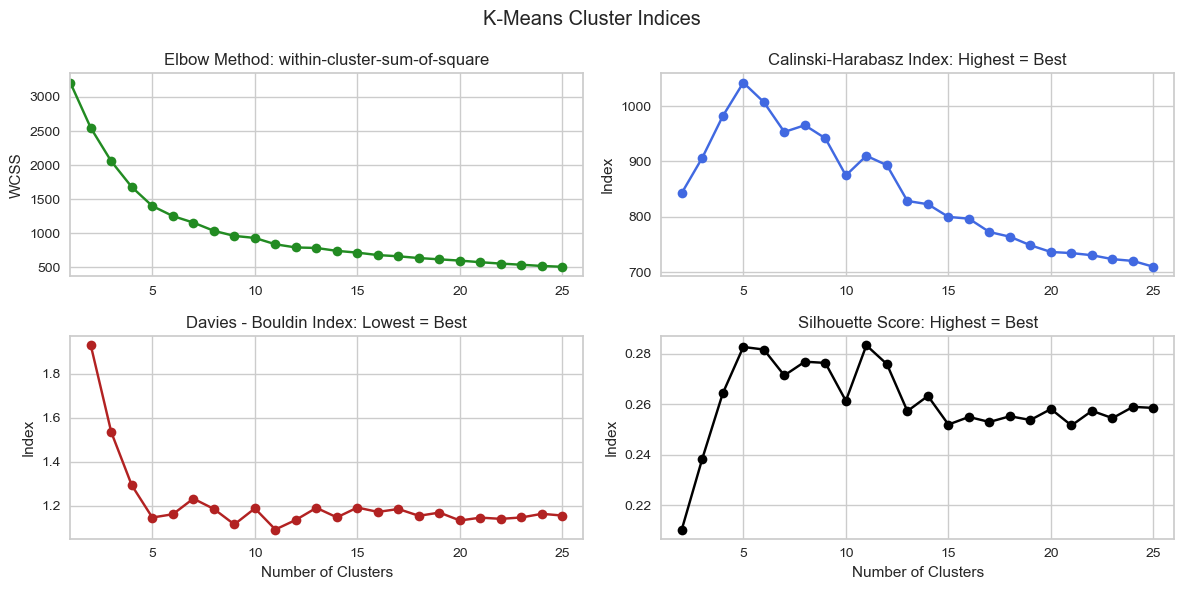

In [12]:
# Conduct k means clustering over a series of cluster sizes to determine optimium number of groups

# Conduct series of k means models and create list to hold Cluster distance values for each sample size
SumError = []
CalinskiIndex = []
DaviesIndex = []
Silhouette = []

MaxN = 26
for k in range(1, MaxN):
    kMeanModel = KMeans(n_clusters=k, n_init='auto', init='k-means++', random_state=42).fit(ClusteringData_Scaled) 
    kMeanModelLabels = kMeanModel.labels_
    
    SumError = np.hstack((SumError, kMeanModel.inertia_))
    
    if k == 1:
        CalinskiIndex = np.hstack((CalinskiIndex, np.nan)) 
        DaviesIndex = np.hstack((DaviesIndex, np.nan))
        Silhouette = np.hstack((Silhouette, np.nan))
    else:
        CalinskiIndex = np.hstack((CalinskiIndex, metrics.calinski_harabasz_score(ClusteringData_Scaled, kMeanModelLabels)))
        DaviesIndex = np.hstack((DaviesIndex, metrics.davies_bouldin_score(ClusteringData_Scaled, kMeanModelLabels)))
        Silhouette = np.hstack((Silhouette, metrics.silhouette_score(ClusteringData_Scaled, kMeanModel.labels_)))

# Visualize 
fig = plt.figure(figsize=(12, 6))
plt.suptitle('K-Means Cluster Indices')

ax1 = plt.subplot(221) # Optimum is where it starts to bend
ax1.set_title('Elbow Method: within-cluster-sum-of-square')
ax1.plot(range(1, MaxN), SumError, marker='o', color='forestgreen')
ax1.set_xlim(1, MaxN)
ax1.set_ylabel("WCSS")
ax1.grid(True)

ax2 = plt.subplot(222) # Optimum is highest
ax2.set_title('Calinski-Harabasz Index: Highest = Best')
ax2.plot(range(1, MaxN), CalinskiIndex, marker='o', color='royalblue')
ax2.set_xlim(1, MaxN)
ax2.set_ylabel("Index")
ax2.grid(True)

ax3 = plt.subplot(223) # Optimum is lowest
ax3.set_title('Davies - Bouldin Index: Lowest = Best')
ax3.plot(range(1, MaxN), DaviesIndex, marker='o', color='firebrick')
ax3.set_xlim(1, MaxN)
ax3.set_xlabel("Number of Clusters")
ax3.set_ylabel("Index")
ax3.grid(True)

ax4 = plt.subplot(224) # Optimum is highest
ax4.set_title('Silhouette Score: Highest = Best')
ax4.plot(range(1, MaxN), Silhouette, marker='o', color='black')
ax4.set_xlim(1, MaxN)
ax4.set_xlabel("Number of Clusters")
ax4.set_ylabel("Index")
ax4.grid(True)

fig.tight_layout()
plt.show()


In [13]:
# Based on metrics above run kMeans to determine the optimum number of clusters

kMeanModel = KMeans(n_clusters=5, n_init='auto', init='k-means++', random_state=42).fit(ClusteringData_Scaled) 

# Isolate Clusters
kMeanClusters = kMeanModel.labels_

Cluster1_Indices = np.squeeze(np.array(np.where(kMeanClusters == 0)))
Cluster2_Indices = np.squeeze(np.array(np.where(kMeanClusters == 1)))
Cluster3_Indices = np.squeeze(np.array(np.where(kMeanClusters == 2)))
Cluster4_Indices = np.squeeze(np.array(np.where(kMeanClusters == 3)))
Cluster5_Indices = np.squeeze(np.array(np.where(kMeanClusters == 4)))

nCluster1 = len(Cluster1_Indices)
nCluster2 = len(Cluster2_Indices)
nCluster3 = len(Cluster3_Indices)
nCluster4 = len(Cluster4_Indices)
nCluster5 = len(Cluster5_Indices)


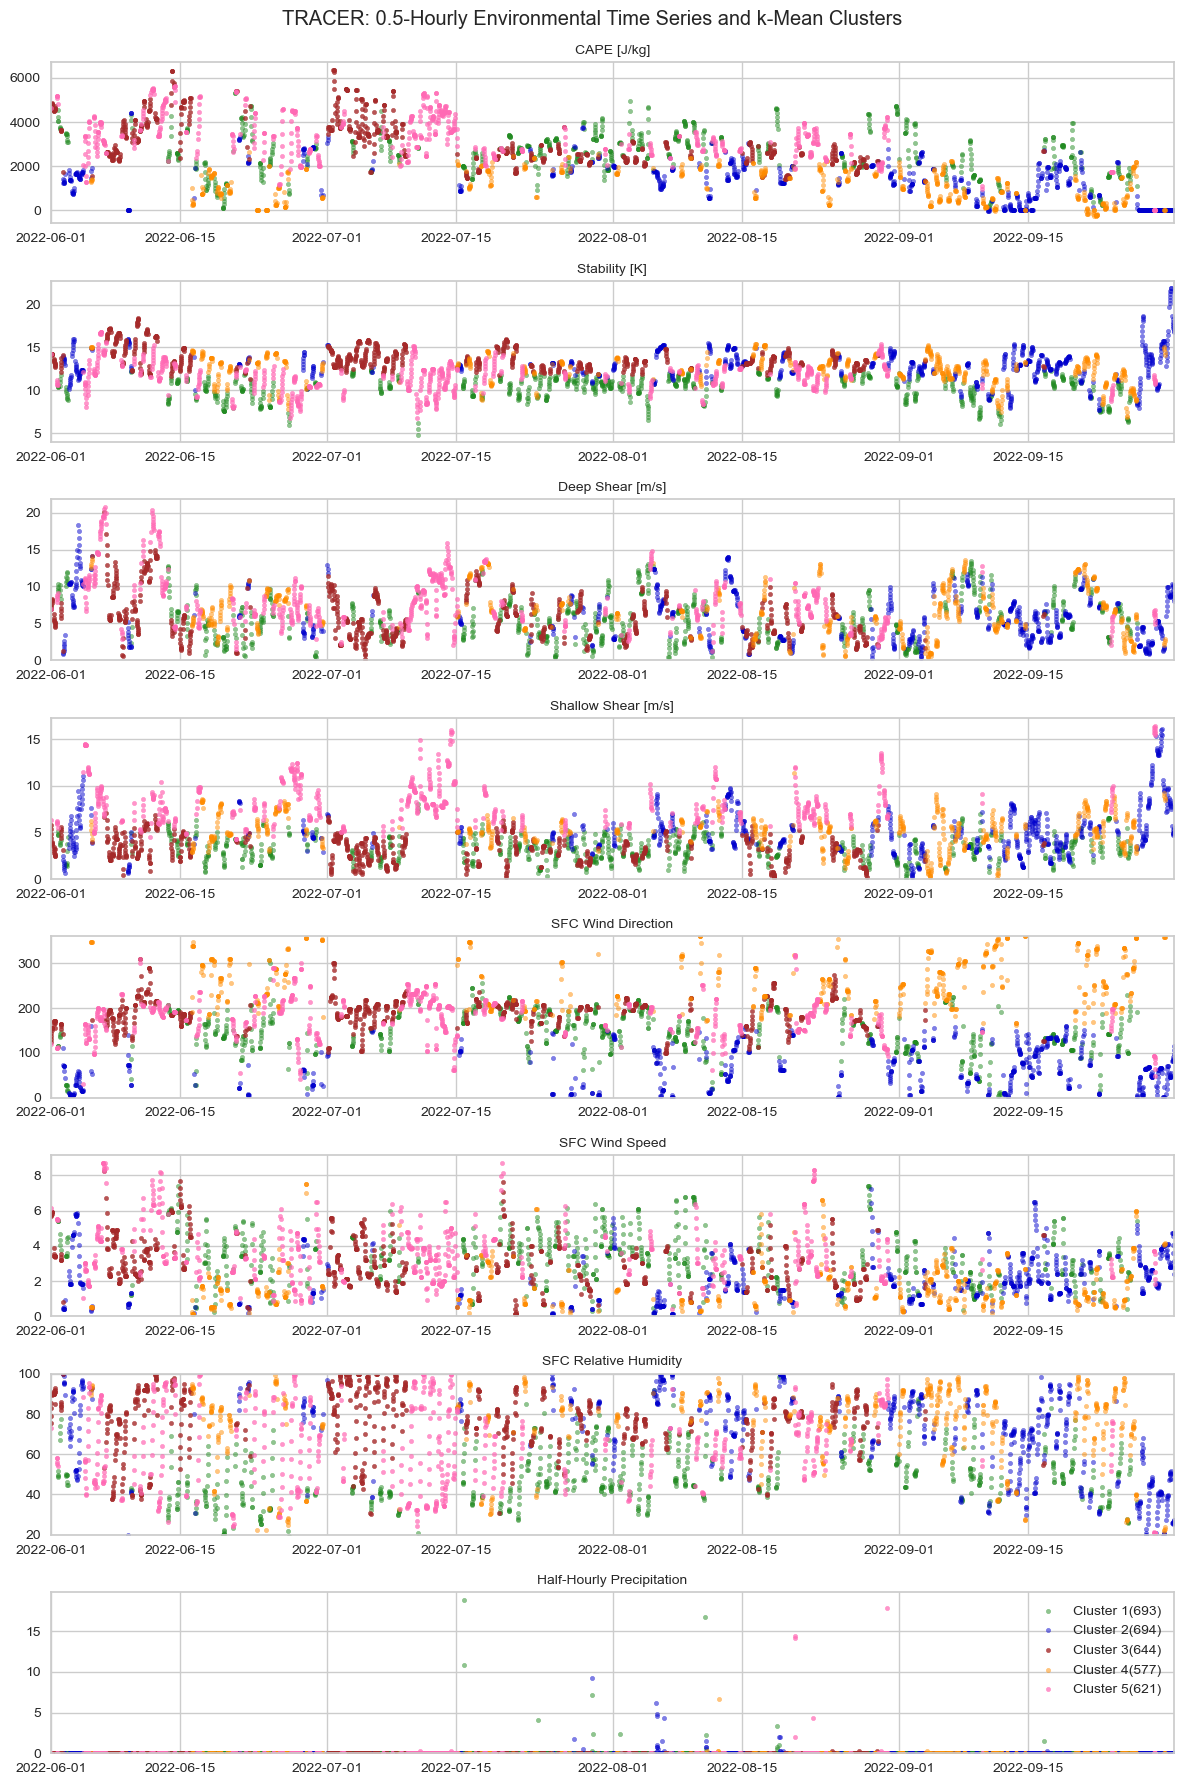

In [21]:
# Plot time series with clusters

fig = plt.figure(figsize=(12, 20))
plt.suptitle(FieldProject + ': ' + str(SetHour) + '-Hourly Environmental Time Series and k-Mean Clusters', y=0.99)

for p in range(0, 8):
    ax = plt.subplot(9,1,int(p+1))
    if p == 0:
        ax.set_title('CAPE [J/kg]', size=10)
        ax.scatter(EnvironmentDateTimes[Cluster1_Indices], CAPE[Cluster1_Indices], s=10, alpha=0.5, color='forestgreen')
        ax.scatter(EnvironmentDateTimes[Cluster2_Indices], CAPE[Cluster2_Indices], s=10, alpha=0.5, color='mediumblue')
        ax.scatter(EnvironmentDateTimes[Cluster3_Indices], CAPE[Cluster3_Indices], s=10, alpha=0.8, color='brown')
        ax.scatter(EnvironmentDateTimes[Cluster4_Indices], CAPE[Cluster4_Indices], s=10, alpha=0.5, color='darkorange')
        ax.scatter(EnvironmentDateTimes[Cluster5_Indices], CAPE[Cluster5_Indices], s=10, alpha=0.7, color='hotpink')
    elif p == 1:
        ax.set_title('Stability [K]', size=10)
        ax.scatter(EnvironmentDateTimes[Cluster1_Indices], Stability[Cluster1_Indices], s=10, alpha=0.5, color='forestgreen')
        ax.scatter(EnvironmentDateTimes[Cluster2_Indices], Stability[Cluster2_Indices], s=10, alpha=0.5, color='mediumblue')
        ax.scatter(EnvironmentDateTimes[Cluster3_Indices], Stability[Cluster3_Indices], s=10, alpha=0.8, color='brown')
        ax.scatter(EnvironmentDateTimes[Cluster4_Indices], Stability[Cluster4_Indices], s=10, alpha=0.5, color='darkorange')
        ax.scatter(EnvironmentDateTimes[Cluster5_Indices], Stability[Cluster5_Indices], s=10, alpha=0.7, color='hotpink')
    elif p == 2:
        ax.set_title('Deep Shear [m/s]', size=10)
        ax.scatter(EnvironmentDateTimes[Cluster1_Indices], DeepShear[Cluster1_Indices], s=10, alpha=0.5, color='forestgreen')
        ax.scatter(EnvironmentDateTimes[Cluster2_Indices], DeepShear[Cluster2_Indices], s=10, alpha=0.5, color='mediumblue')
        ax.scatter(EnvironmentDateTimes[Cluster3_Indices], DeepShear[Cluster3_Indices], s=10, alpha=0.8, color='brown')
        ax.scatter(EnvironmentDateTimes[Cluster4_Indices], DeepShear[Cluster4_Indices], s=10, alpha=0.5, color='darkorange')
        ax.scatter(EnvironmentDateTimes[Cluster5_Indices], DeepShear[Cluster5_Indices], s=10, alpha=0.7, color='hotpink')
        ax.set_ylim(bottom=0)
    elif p == 3:
        ax.set_title('Shallow Shear [m/s]', size=10)
        ax.scatter(EnvironmentDateTimes[Cluster1_Indices], ShallowShear[Cluster1_Indices], s=10, alpha=0.5, color='forestgreen')
        ax.scatter(EnvironmentDateTimes[Cluster2_Indices], ShallowShear[Cluster2_Indices], s=10, alpha=0.5, color='mediumblue')
        ax.scatter(EnvironmentDateTimes[Cluster3_Indices], ShallowShear[Cluster3_Indices], s=10, alpha=0.8, color='brown')
        ax.scatter(EnvironmentDateTimes[Cluster4_Indices], ShallowShear[Cluster4_Indices], s=10, alpha=0.5, color='darkorange')
        ax.scatter(EnvironmentDateTimes[Cluster5_Indices], ShallowShear[Cluster5_Indices], s=10, alpha=0.7, color='hotpink')
        ax.set_ylim(bottom=0)
    elif p == 4:
        ax.set_title('SFC Wind Direction', size=10)
        ax.scatter(EnvironmentDateTimes[Cluster1_Indices], SFCWindDirection[Cluster1_Indices], s=10, alpha=0.5, color='forestgreen')
        ax.scatter(EnvironmentDateTimes[Cluster2_Indices], SFCWindDirection[Cluster2_Indices], s=10, alpha=0.5, color='mediumblue')
        ax.scatter(EnvironmentDateTimes[Cluster3_Indices], SFCWindDirection[Cluster3_Indices], s=10, alpha=0.8, color='brown')
        ax.scatter(EnvironmentDateTimes[Cluster4_Indices], SFCWindDirection[Cluster4_Indices], s=10, alpha=0.5, color='darkorange')
        ax.scatter(EnvironmentDateTimes[Cluster5_Indices], SFCWindDirection[Cluster5_Indices], s=10, alpha=0.7, color='hotpink')
        ax.set_ylim(0, 360)
    elif p == 5:
        ax.set_title('SFC Wind Speed', size=10)
        ax.scatter(EnvironmentDateTimes[Cluster1_Indices], SFCWindSpeed[Cluster1_Indices], s=10, alpha=0.5, color='forestgreen', 
                   label='Cluster 1')
        ax.scatter(EnvironmentDateTimes[Cluster2_Indices], SFCWindSpeed[Cluster2_Indices], s=10, alpha=0.5, color='mediumblue', 
                   label='Cluster 2')
        ax.scatter(EnvironmentDateTimes[Cluster3_Indices], SFCWindSpeed[Cluster3_Indices], s=10, alpha=0.8, color='brown', 
                   label='Cluster 3')
        ax.scatter(EnvironmentDateTimes[Cluster4_Indices], SFCWindSpeed[Cluster4_Indices], s=10, alpha=0.5, color='darkorange', 
                   label='Cluster 4')
        ax.scatter(EnvironmentDateTimes[Cluster5_Indices], SFCWindSpeed[Cluster5_Indices], s=10, alpha=0.7, color='hotpink', 
                   label='Cluster 5')
        ax.set_ylim(bottom=0)
    elif p == 6:
        ax.set_title('SFC Relative Humidity', size=10)
        ax.scatter(EnvironmentDateTimes[Cluster1_Indices], SFCRelativeHumidity[Cluster1_Indices], s=10, alpha=0.5, color='forestgreen', 
                   label='Cluster 1')
        ax.scatter(EnvironmentDateTimes[Cluster2_Indices], SFCRelativeHumidity[Cluster2_Indices], s=10, alpha=0.5, color='mediumblue', 
                   label='Cluster 2')
        ax.scatter(EnvironmentDateTimes[Cluster3_Indices], SFCRelativeHumidity[Cluster3_Indices], s=10, alpha=0.8, color='brown', 
                   label='Cluster 3')
        ax.scatter(EnvironmentDateTimes[Cluster4_Indices], SFCRelativeHumidity[Cluster4_Indices], s=10, alpha=0.5, color='darkorange', 
                   label='Cluster 4')
        ax.scatter(EnvironmentDateTimes[Cluster5_Indices], SFCRelativeHumidity[Cluster5_Indices], s=10, alpha=0.7, color='hotpink', 
                   label='Cluster 5')
        ax.set_ylim(20, 100)
    elif p == 7:
        ax.set_title('Half-Hourly Precipitation', size=10)
        ax.scatter(EnvironmentDateTimes[Cluster1_Indices], MatchedPrecipitation[Cluster1_Indices], s=10, alpha=0.5, color='forestgreen', 
                    label='Cluster 1(' + str(nCluster1) + ')')
        ax.scatter(EnvironmentDateTimes[Cluster2_Indices], MatchedPrecipitation[Cluster2_Indices], s=10, alpha=0.5, color='mediumblue', 
                    label='Cluster 2(' + str(nCluster2) + ')')
        ax.scatter(EnvironmentDateTimes[Cluster3_Indices], MatchedPrecipitation[Cluster3_Indices], s=10, alpha=0.8, color='brown', 
                    label='Cluster 3(' + str(nCluster3) + ')')
        ax.scatter(EnvironmentDateTimes[Cluster4_Indices], MatchedPrecipitation[Cluster4_Indices], s=10, alpha=0.5, color='darkorange', 
                    label='Cluster 4(' + str(nCluster4) + ')')
        ax.scatter(EnvironmentDateTimes[Cluster5_Indices], MatchedPrecipitation[Cluster5_Indices], s=10, alpha=0.7, color='hotpink', 
                    label='Cluster 5(' + str(nCluster5) + ')')
        ax.legend(loc='best', fontsize=10)
        ax.set_ylim(bottom=0)

    ax.set_xlim(EnvironmentDateTimes[0], EnvironmentDateTimes[-1])
    ax.grid(True)

plt.tight_layout()
plt.savefig(PlotDirectory + FieldProject + '_Interpsonde_KMeanClusterTimeSeries.png', transparent=False, dpi=300)
#plt.show()


In [22]:
# Calculate statistics of each cluster

# CAPE 
CAPE_Cluster1 = CAPE[Cluster1_Indices]
CAPE_Cluster2 = CAPE[Cluster2_Indices]
CAPE_Cluster3 = CAPE[Cluster3_Indices]
CAPE_Cluster4 = CAPE[Cluster4_Indices]
CAPE_Cluster5 = CAPE[Cluster5_Indices]

# Stability 
Stability_Cluster1 = Stability[Cluster1_Indices]
Stability_Cluster2 = Stability[Cluster2_Indices]
Stability_Cluster3 = Stability[Cluster3_Indices]
Stability_Cluster4 = Stability[Cluster4_Indices]
Stability_Cluster5 = Stability[Cluster5_Indices]

# Shallow Shear
ShallowShear_Cluster1 = ShallowShear[Cluster1_Indices]
ShallowShear_Cluster2 = ShallowShear[Cluster2_Indices]
ShallowShear_Cluster3 = ShallowShear[Cluster3_Indices]
ShallowShear_Cluster4 = ShallowShear[Cluster4_Indices]
ShallowShear_Cluster5 = ShallowShear[Cluster5_Indices]

# Deep Shear
DeepShear_Cluster1 = DeepShear[Cluster1_Indices]
DeepShear_Cluster2 = DeepShear[Cluster2_Indices]
DeepShear_Cluster3 = DeepShear[Cluster3_Indices]
DeepShear_Cluster4 = DeepShear[Cluster4_Indices]
DeepShear_Cluster5 = DeepShear[Cluster5_Indices]

# SFC Wind Direction
SFCWindDirection_Cluster1 = SFCWindDirection[Cluster1_Indices]
SFCWindDirection_Cluster2 = SFCWindDirection[Cluster2_Indices]
SFCWindDirection_Cluster3 = SFCWindDirection[Cluster3_Indices]
SFCWindDirection_Cluster4 = SFCWindDirection[Cluster4_Indices]
SFCWindDirection_Cluster5 = SFCWindDirection[Cluster5_Indices]

# SFC Wind Speed
SFCWindSpeed_Cluster1 = SFCWindSpeed[Cluster1_Indices]
SFCWindSpeed_Cluster2 = SFCWindSpeed[Cluster2_Indices]
SFCWindSpeed_Cluster3 = SFCWindSpeed[Cluster3_Indices]
SFCWindSpeed_Cluster4 = SFCWindSpeed[Cluster4_Indices]
SFCWindSpeed_Cluster5 = SFCWindSpeed[Cluster5_Indices]

# Precipitation
Precipitation_Cluster1 = MatchedPrecipitation[Cluster1_Indices]
Precipitation_Cluster2 = MatchedPrecipitation[Cluster2_Indices]
Precipitation_Cluster3 = MatchedPrecipitation[Cluster3_Indices]
Precipitation_Cluster4 = MatchedPrecipitation[Cluster4_Indices]
Precipitation_Cluster5 = MatchedPrecipitation[Cluster5_Indices]

# Aerosols
Aerosols_Cluster1 = MatchedAerosols[Cluster1_Indices]
Aerosols_Cluster2 = MatchedAerosols[Cluster2_Indices]
Aerosols_Cluster3 = MatchedAerosols[Cluster3_Indices]
Aerosols_Cluster4 = MatchedAerosols[Cluster4_Indices]
Aerosols_Cluster5 = MatchedAerosols[Cluster5_Indices]


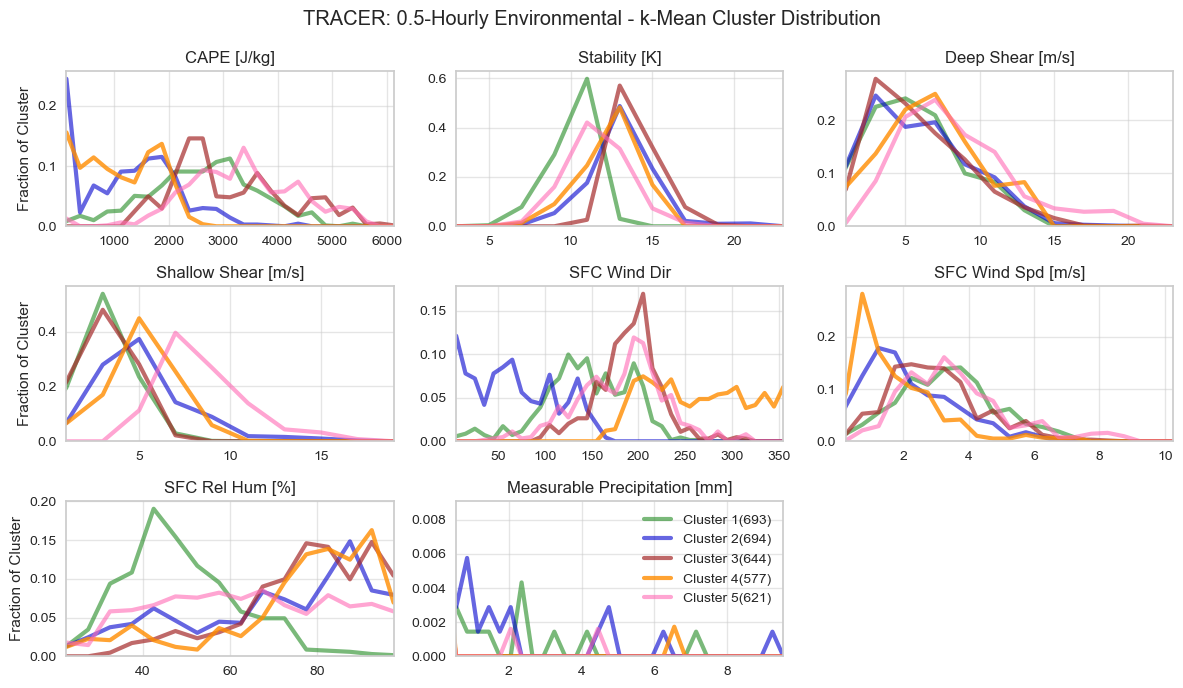

In [23]:
# Create histograms

fig = plt.figure(figsize=(12, 7))
plt.suptitle(FieldProject + ': ' + str(SetHour) + '-Hourly Environmental - k-Mean Cluster Distribution')

for p in range(0, 8):
    if p == 0:
        Name = 'CAPE [J/kg]'
        Histogram1, bins = np.histogram(CAPE[Cluster1_Indices], bins=np.arange(-250, 6500, 250))
        Histogram2, bins = np.histogram(CAPE[Cluster2_Indices], bins=np.arange(-250, 6500, 250))
        Histogram3, bins = np.histogram(CAPE[Cluster3_Indices], bins=np.arange(-250, 6500, 250))
        Histogram4, bins = np.histogram(CAPE[Cluster4_Indices], bins=np.arange(-250, 6500, 250))
        Histogram5, bins = np.histogram(CAPE[Cluster5_Indices], bins=np.arange(-250, 6500, 250))
    elif p == 1:
        Name = 'Stability [K]'
        Histogram1, bins = np.histogram(Stability[Cluster1_Indices], bins=np.arange(0, 26, 2))
        Histogram2, bins = np.histogram(Stability[Cluster2_Indices], bins=np.arange(0, 26, 2))
        Histogram3, bins = np.histogram(Stability[Cluster3_Indices], bins=np.arange(0, 26, 2))
        Histogram4, bins = np.histogram(Stability[Cluster4_Indices], bins=np.arange(0, 26, 2))
        Histogram5, bins = np.histogram(Stability[Cluster5_Indices], bins=np.arange(0, 26, 2))
    elif p == 2:
        Name = 'Deep Shear [m/s]'
        Histogram1, bins = np.histogram(DeepShear[Cluster1_Indices], bins=np.arange(-2, 26, 2))
        Histogram2, bins = np.histogram(DeepShear[Cluster2_Indices], bins=np.arange(-2, 26, 2))
        Histogram3, bins = np.histogram(DeepShear[Cluster3_Indices], bins=np.arange(-2, 26, 2))
        Histogram4, bins = np.histogram(DeepShear[Cluster4_Indices], bins=np.arange(-2, 26, 2))
        Histogram5, bins = np.histogram(DeepShear[Cluster5_Indices], bins=np.arange(-2, 26, 2))
    elif p == 3:
        Name = 'Shallow Shear [m/s]'
        Histogram1, bins = np.histogram(ShallowShear[Cluster1_Indices], bins=np.arange(-2, 21, 2))
        Histogram2, bins = np.histogram(ShallowShear[Cluster2_Indices], bins=np.arange(-2, 21, 2))
        Histogram3, bins = np.histogram(ShallowShear[Cluster3_Indices], bins=np.arange(-2, 21, 2))
        Histogram4, bins = np.histogram(ShallowShear[Cluster4_Indices], bins=np.arange(-2, 21, 2))
        Histogram5, bins = np.histogram(ShallowShear[Cluster5_Indices], bins=np.arange(-2, 21, 2))
    elif p == 4:
        Name = 'SFC Wind Dir'
        Histogram1, bins = np.histogram(SFCWindDirection[Cluster1_Indices], bins=np.arange(-10, 370, 10))
        Histogram2, bins = np.histogram(SFCWindDirection[Cluster2_Indices], bins=np.arange(-10, 370, 10))
        Histogram3, bins = np.histogram(SFCWindDirection[Cluster3_Indices], bins=np.arange(-10, 370, 10))
        Histogram4, bins = np.histogram(SFCWindDirection[Cluster4_Indices], bins=np.arange(-10, 370, 10))
        Histogram5, bins = np.histogram(SFCWindDirection[Cluster5_Indices], bins=np.arange(-10, 370, 10))
    elif p == 5:
        Name = 'SFC Wind Spd [m/s]'
        Histogram1, bins = np.histogram(SFCWindSpeed[Cluster1_Indices], bins=np.arange(-0.5, 11, 0.5))
        Histogram2, bins = np.histogram(SFCWindSpeed[Cluster2_Indices], bins=np.arange(-0.5, 11, 0.5))
        Histogram3, bins = np.histogram(SFCWindSpeed[Cluster3_Indices], bins=np.arange(-0.5, 11, 0.5))
        Histogram4, bins = np.histogram(SFCWindSpeed[Cluster4_Indices], bins=np.arange(-0.5, 11, 0.5))
        Histogram5, bins = np.histogram(SFCWindSpeed[Cluster5_Indices], bins=np.arange(-0.5, 11, 0.5))
    elif p == 6:
        Name = 'SFC Rel Hum [%]'
        Histogram1, bins = np.histogram(SFCRelativeHumidity[Cluster1_Indices], bins=np.arange(15, 105, 5))
        Histogram2, bins = np.histogram(SFCRelativeHumidity[Cluster2_Indices], bins=np.arange(15, 105, 5))
        Histogram3, bins = np.histogram(SFCRelativeHumidity[Cluster3_Indices], bins=np.arange(15, 105, 5))
        Histogram4, bins = np.histogram(SFCRelativeHumidity[Cluster4_Indices], bins=np.arange(15, 105, 5))
        Histogram5, bins = np.histogram(SFCRelativeHumidity[Cluster5_Indices], bins=np.arange(15, 105, 5))
    elif p == 7:
        Name = 'Measurable Precipitation [mm]'
        Histogram1, bins = np.histogram(MatchedPrecipitation[Cluster1_Indices], bins=np.arange(0.1, 10, 0.3))
        Histogram2, bins = np.histogram(MatchedPrecipitation[Cluster2_Indices], bins=np.arange(0.1, 10, 0.3))
        Histogram3, bins = np.histogram(MatchedPrecipitation[Cluster3_Indices], bins=np.arange(0.1, 10, 0.3))
        Histogram4, bins = np.histogram(MatchedPrecipitation[Cluster4_Indices], bins=np.arange(0.1, 10, 0.3))
        Histogram5, bins = np.histogram(MatchedPrecipitation[Cluster5_Indices], bins=np.arange(0.1, 10, 0.3))
    bins = (bins[1:]+bins[:-1])/2.0

    Histogram1 = Histogram1/nCluster1
    Histogram2 = Histogram2/nCluster2
    Histogram3 = Histogram3/nCluster3
    Histogram4 = Histogram4/nCluster4
    Histogram5 = Histogram5/nCluster5

    ax = plt.subplot(3,3,int(p+1))
    ax.set_title(Name)
    ax.plot(bins, Histogram1, linewidth=3, color='forestgreen', alpha=0.6, label='Cluster 1(' + str(nCluster1) + ')')
    ax.plot(bins, Histogram2, linewidth=3, color='mediumblue', alpha=0.6, label='Cluster 2(' + str(nCluster2) + ')')  
    ax.plot(bins, Histogram3, linewidth=3, color='brown', alpha=0.7, label='Cluster 3(' + str(nCluster3) + ')')
    ax.plot(bins, Histogram4, linewidth=3, color='darkorange', alpha=0.8, label='Cluster 4(' + str(nCluster4) + ')')
    ax.plot(bins, Histogram5, linewidth=3, color='hotpink', alpha=0.6, label='Cluster 5(' + str(nCluster5) + ')')
    if p == 7:
        plt.legend(loc='best')
    if p == 0 or p == 3 or p == 6:
        ax.set_ylabel('Fraction of Cluster')
    ax.set_ylim(bottom=0)
    ax.set_xlim(bins[1], bins[-1])
    ax.grid(True, alpha=0.5)

plt.tight_layout()
#plt.savefig(PlotDirectory + FieldProject + '_Interpsonde_KMeanClusterHistogram.png', transparent=False, dpi=300)
plt.show()


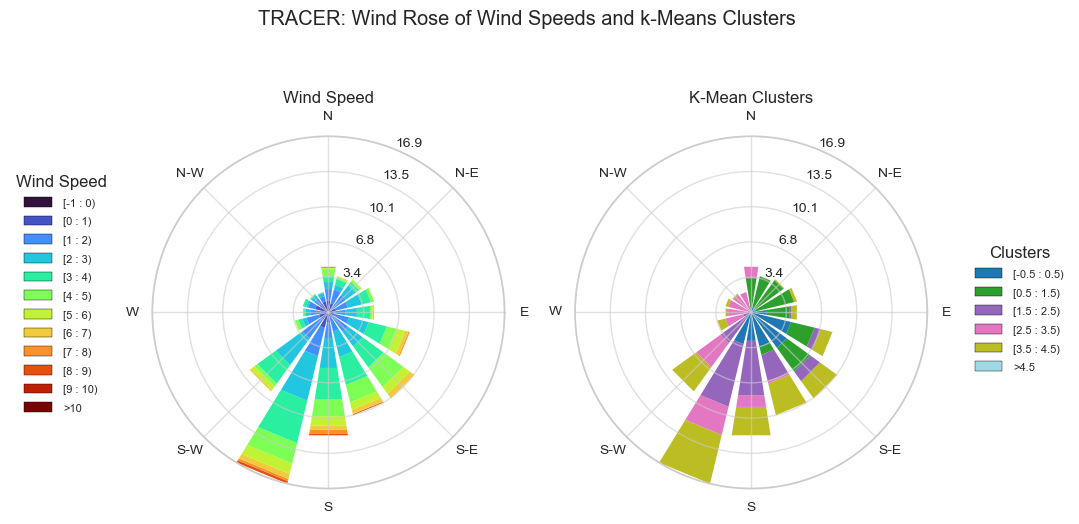

In [24]:
# Plot wind rose of categories

labels = ["E", "NE", "N", "NW", "W", "SW", "S", "SE"]

fig = plt.figure(figsize=(10, 5))
plt.suptitle(FieldProject + ': Wind Rose of Wind Speeds and k-Means Clusters', y=1.1)

ax1 = fig.add_subplot(1, 2, 1, projection="windrose")
ax1.set_title('Wind Speed')
ax1.bar(SFCWindDirection, SFCWindSpeed, bins=np.arange(-1, 11, 1), normed=True, cmap=plt.cm.turbo)

ax1.set_legend(title = 'Wind Speed', bbox_to_anchor=(-0.4, 0.2), edgecolor='white', decimal_places=0)
ax1.grid(True, alpha=0.6)

ax2 = fig.add_subplot(1, 2, 2, projection="windrose")
ax2.set_title('K-Mean Clusters')
ax2.bar(SFCWindDirection, kMeanClusters, bins=np.arange(-0.5, 5.5, 1), normed=True, cmap=plt.cm.tab20)
ax2.set_legend(title='Clusters', loc='best', bbox_to_anchor=(1.4, 0.7), edgecolor='white', decimal_places=1)
ax2.grid(True, alpha=0.6)

plt.savefig(PlotDirectory + FieldProject + '_Interpsonde_kMeanWindRose.png', transparent=False, dpi=300)
plt.show()


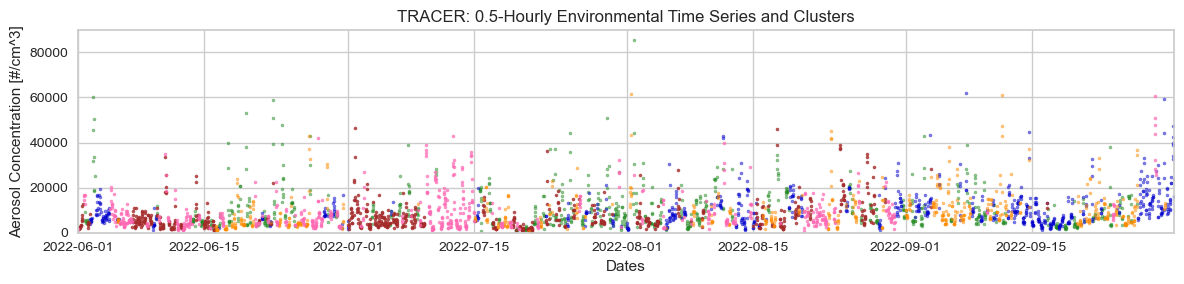

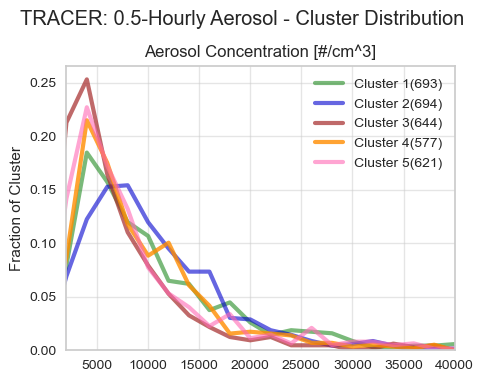

In [25]:
# Plot clusters and aerosols

# Time series
plt.figure(figsize=(12, 3))
plt.title(FieldProject + ': ' + str(SetHour) + '-Hourly Environmental Time Series and Clusters')
plt.scatter(EnvironmentDateTimes[Cluster1_Indices], MatchedAerosols[Cluster1_Indices], s=5, alpha=0.5, color='forestgreen')
plt.scatter(EnvironmentDateTimes[Cluster2_Indices], MatchedAerosols[Cluster2_Indices], s=5, alpha=0.5, color='mediumblue')
plt.scatter(EnvironmentDateTimes[Cluster3_Indices], MatchedAerosols[Cluster3_Indices], s=5, alpha=0.8, color='brown')
plt.scatter(EnvironmentDateTimes[Cluster4_Indices], MatchedAerosols[Cluster4_Indices], s=5, alpha=0.5, color='darkorange')
plt.scatter(EnvironmentDateTimes[Cluster5_Indices], MatchedAerosols[Cluster5_Indices], s=5, alpha=0.7, color='hotpink')
plt.xlim(EnvironmentDateTimes[0], EnvironmentDateTimes[-1])
plt.ylabel('Aerosol Concentration [#/cm^3]')
plt.ylim(bottom=0)
plt.xlabel('Dates')
plt.grid(True)

plt.tight_layout()
plt.savefig(PlotDirectory + FieldProject + '_Interpsonde_KMeanClusterAerosolTimeSeries.png', transparent=False, dpi=300)
plt.show()


# Histograms
fig = plt.figure(figsize=(5, 4))
plt.suptitle(FieldProject + ': ' + str(SetHour) + '-Hourly Aerosol - Cluster Distribution', y=0.95)

Name = 'Aerosol Concentration [#/cm^3]'
Histogram1, bins = np.histogram(MatchedAerosols[Cluster1_Indices], bins=np.arange(-1000, 42000, 2000))
Histogram2, bins = np.histogram(MatchedAerosols[Cluster2_Indices], bins=np.arange(-1000, 42000, 2000))
Histogram3, bins = np.histogram(MatchedAerosols[Cluster3_Indices], bins=np.arange(-1000, 42000, 2000))
Histogram4, bins = np.histogram(MatchedAerosols[Cluster4_Indices], bins=np.arange(-1000, 42000, 2000))
Histogram5, bins = np.histogram(MatchedAerosols[Cluster5_Indices], bins=np.arange(-1000, 42000, 2000))
bins = (bins[1:]+bins[:-1])/2.0

Histogram1 = Histogram1/nCluster1
Histogram2 = Histogram2/nCluster2
Histogram3 = Histogram3/nCluster3
Histogram4 = Histogram4/nCluster4
Histogram5 = Histogram5/nCluster5

ax = plt.subplot(111)
ax.set_title(Name)
ax.plot(bins, Histogram1, linewidth=3, color='forestgreen', alpha=0.6, label='Cluster 1(' + str(nCluster1) + ')')
ax.plot(bins, Histogram2, linewidth=3, color='mediumblue', alpha=0.6, label='Cluster 2(' + str(nCluster2) + ')')  
ax.plot(bins, Histogram3, linewidth=3, color='brown', alpha=0.7, label='Cluster 3(' + str(nCluster3) + ')')
ax.plot(bins, Histogram4, linewidth=3, color='darkorange', alpha=0.8, label='Cluster 4(' + str(nCluster4) + ')')
ax.plot(bins, Histogram5, linewidth=3, color='hotpink', alpha=0.6, label='Cluster 5(' + str(nCluster5) + ')')
plt.legend(loc='best', fontsize=10)
ax.set_ylabel('Fraction of Cluster')
ax.set_xlim(bins[1], bins[-1])
ax.set_ylim(bottom=0)
ax.grid(True, alpha=0.5)

plt.tight_layout()
plt.savefig(PlotDirectory + FieldProject + '_Interpsonde_KMeanClusterAerosolHistogram.png', transparent=False, dpi=300)
plt.show()
